# Fire Smoke Estimates for Longview, Washington

This analysis involves investigating the impact of fires on Longview, Washington. For the purpose of this project, I will focus on the last 60 years of wildland fires, will consider fires that are within 1250 miles of this city, and will consider an annual fire season to be from May 1st - October 31st.

I have chosen to include both "wildfires" and "prescribed fires" in my analysis. According to the paper [*Impact of smoke from prescribed burning: Is it a public health concern?*](https://pubmed.ncbi.nlm.nih.gov/25947317/#:~:text=Smoke%20from%20prescribed%20burning%20can,consistently%20elevated%20during%20smoke%20events.), smoke from prescribed burning still has a significant impact on air quality and the environment. Thus, I believe that both wildfires and prescribed fires should be included in my overall smoke estimates.

## Data Acquisition: Wildland Fire Datasets

To begin, I collect historical data regarding wildfires in the United States. This dataset was aggregated by the US Geological Survey and is titled *Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons).* I downloaded this data to my local device in the GeoJSON format, accessed at this [link](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) on 11/2/2023.

Code in an example notebook ([Wildfire Proximity Computation Example](https://drive.google.com/file/d/1qNI6hji8CvDeBsnLDAhJXvaqf2gcg8UV/view?usp=drive_link)), provided by Dr. David W McDonald, has been modified and used below. This code has been provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.0 - August 13, 2023.

The code below has dependencies on [Pyproj](https://pyproj4.github.io/pyproj/stable/index.html) and the GeoJSON module ([documentation](https://pypi.org/project/geojson/), [GitHub repo](https://github.com/jazzband/geojson)), which can be installed via pip.

First, we import modules needed for this analysis, and open the GeoJSON files.

In [345]:
# Code from Dr. McDonald
#    IMPORTS
# 

#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#    
import geojson

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The frame.append method is deprecated and will be removed from pandas in a future version.")

import seaborn as sns

In [2]:
# Code from Dr. McDonald
#    CONSTANTS
#

# Define the name and path of the GeoJSON file
EXTRACT_FILENAME = "C:\\Users\\tejal\\Downloads\\GeoJSON Files\\GeoJSON Exports\\USGS_Wildland_Fire_Combined_Dataset.json"

In [3]:
# Code from Dr. McDonald
#    Open a file, load it with the geojson loader

SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()
#
#    For all GeoJSON type things, the most important part of the file are the 'features'. 
#    In the case of the wildfire dataset, each feature is a polygon (ring) of points that define the bounary of a fire
#
    
length = len(gj_data['features'])

print(f"Found {length} features in the variable 'gj_data' ")

The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']

Found 135061 features in the variable 'gj_data' 


The next step is to filter the data for the years we are interested in. Since we are interested in wildfire data from the last 60 years, we will filter the data for instances where the year is greater than or equal to 1963. Please note that our dataset only contains data for up to 2020.

In [4]:
# Obtain list of features
gj_feature = gj_data['features']

In [5]:
# Obtain year for each feature
years = []

for i in range(0, len(gj_feature)):
    year = gj_feature[i]['attributes']['Fire_Year']
    years.append(year)

In [6]:
gj_df = pd.DataFrame(list(zip(gj_feature, years)), columns =['feature', 'year'])

In [7]:
# Filter data for years greater than or equal to 1963
gj_df = gj_df[gj_df['year'] >= 1963].reset_index(drop=True)
gj_df.head()

,feature,year
0,"{'attributes': {'OBJECTID': 14299, 'USGS_Assig...",1963
1,"{'attributes': {'OBJECTID': 14300, 'USGS_Assig...",1963
2,"{'attributes': {'OBJECTID': 14301, 'USGS_Assig...",1963
3,"{'attributes': {'OBJECTID': 14302, 'USGS_Assig...",1963
4,"{'attributes': {'OBJECTID': 14303, 'USGS_Assig...",1963


In [8]:
# Obtain list of features for relevant years

gj_feature_years = gj_df['feature']

Now, we are interested in extracting geographic data, specifically, the coordinate rings of each fire. We first extract all coordinate rings for each fire. Then, we extract the biggest ring of each fire and save this in a list called *gj_biggest_ring*. We choose to extract the biggest ring as this represents the greatest area covered for each fire. This will allow us to use a consistent measure when comparing the smoke impact of each fire.

In [9]:
# Code from Dr. McDonald

#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.

# Extract list of geometry for each feature
gj_geometry = []

for i in range(0, len(gj_feature_years)):
    geom = gj_feature_years[i]['geometry']
    gj_geometry.append(geom)

In [10]:
# Extract list of biggest rings

gj_biggest_ring = []

for i in range(0, len(gj_geometry)):
    if 'rings' in gj_geometry[i]:
        ring = gj_geometry[i]['rings'][0]
    
    else:
        ring = 'NULL'
        
    gj_biggest_ring.append(ring)

At this stage, there are 35 values where the geographic rings are in a different format (curveRings). Since this is such a small number, we will exclude these values in our analysis and consider them "NULL" for the time being.

The next step is to convert points between geodetic coordinate systems. The original wildfire dataset uses the well-known ID (WKID) 102008 coordinate system, also known as the  [ESRI:102008](https://epsg.io/102008) coordinate system. For the purposes of our analysis, we will be using the decimal degrees coordinate system, which has an official name (or WKID) of [EPSG:4326](https://epsg.io/4326).

The function below, *convert_ring_to_epsg4326* defines logic for converting points. We use this function to convert points in our *gj_biggest_ring* list created above.

In [11]:
# Code from Dr. McDonald
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

As the code below will take some time to complete, we install and use the [tqdm](https://tqdm.github.io/) package to track progress. The idea to use this technique was suggested by Wanwei Huang, another student in the University of Washington Master of Science in Data Science program. We iterate through each of the coordinate sets in the *gj_biggest_ring* list to convert the coordinates.

In [12]:
from tqdm import tqdm

converted_rings = []

# Use function to convert each ring
for i in tqdm(range(0, len(gj_biggest_ring))):
    if gj_biggest_ring[i]=="NULL":
        conv = "NULL"
    else:
        conv = convert_ring_to_epsg4326(gj_biggest_ring[i])
    converted_rings.append(conv)

100%|████████████████████████████████████████████████████████████████████████| 117578/117578 [1:58:35<00:00, 16.52it/s]


The next step is to compute the distance between Longview, Washington, and each wildfire. For the purposes of this analysis, we will compute the distance to the approximate centroid of the fire region. Specifically, this is done by computing the average distance of all the perimeter points to the city, and returning the average as the distance.

I have chosen to use the centroid of the fire region to compute the distance as opposed to another measure, as I believe that this will give us the most accurate estimates. I make the assumption that fires with a centroid closer to the city will result in a higher smoke impact than fires with a centroid further from the city. Using perimeter estimates, for example, will not allow me to make such a comparison as there could be fires with a perimeter very close to the city but a centroid that is much further, resulting in a minimal smoke impact.

In [14]:
# Code from Dr. McDonald

#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = ring_data    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

We now apply this function for each of the fires. Using [ESPG.io](https://epsg.io/map#srs=4326&x=-122.965558&y=46.142614&z=13&layer=streets), we determine that the coordinates of Longview, Washington are (46.142614, -122.965558). We save these distances in a list called *distances*.

In [39]:
# Longview coordinates

latlon = [46.142614, -122.965558]

distances = []

for i in tqdm(range(0, len(converted_rings))):
    if(converted_rings[i])=='NULL':
        dist = 'NULL'
    else:
        dist = average_distance_from_place_to_fire_perimeter(latlon, converted_rings[i])
    
    distances.append(dist)

100%|████████████████████████████████████████████████████████████████████████| 117578/117578 [01:30<00:00, 1300.40it/s]


Now, we will filter our dataset to only include fires that occured within (less than or equal to) 1250 miles of Longview.

In [50]:
gj_df_dist = pd.DataFrame(list(zip(gj_feature_years, distances)), columns =['feature', 'distance'])
gj_df_dist['distance'] = pd.to_numeric(gj_df_dist['distance'], errors='coerce')

In [53]:
gj_df_dist = gj_df_dist[gj_df_dist['distance'] <= 1250].reset_index(drop=True)
len(gj_df_dist)

73747

In [25]:
# View data
gj_df_dist.head()

,feature,distance
0,0,335.207190
1,1,307.407123
2,2,340.695973
3,3,408.155775
4,4,350.655777


Thus, there were 73747 fires that occured within 1250 miles of Longview, Washington in the last 60 years. Our further analysis will comprise of this data.

## Creating Fire Smoke Estimates
### Data Exploration

The next step is to create an annual estimate of wildfire smoke for Longview. To begin, we will explore the attributes contained in this dataset. First, it would be interesting to see the distribution of distances among wildfires. To visualize this data, I create a histogram.

In [3]:
# Load data from csv file created above
gj_df_dist = pd.read_csv('gj_df_dist.csv')

# Convert column to dictionary format
gj_df_dist['feature'] = gj_df_dist['feature'].apply(lambda x: eval(x) if x else {})

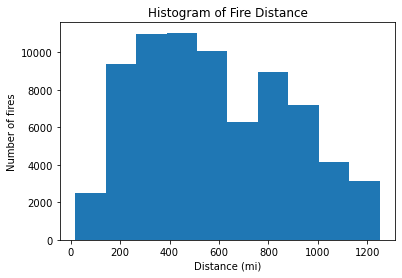

In [4]:
plt.hist(gj_df_dist['distance'])
plt.title("Histogram of Fire Distance")
plt.ylabel("Number of fires")
plt.xlabel("Distance (mi)")
plt.show()

In [6]:
# Closest fire
min(gj_df_dist['distance'])

18.25101445955176

From the histogram above, it appears that the distribution is approximately bimodal, with one peak occurring around 400 miles and another peak occurring around 800 miles. The closest fire that occurred was about 18 miles away. We next conduct a similar analysis to examine the number of fires that occurred each year.

We use the Counter module to count the number of fires that occurred each year.

In [7]:
year_extract = []

for i in range(0, len(gj_df_dist)):
    yr = gj_df_dist['feature'][i]['attributes']['Fire_Year']
    year_extract.append(yr)

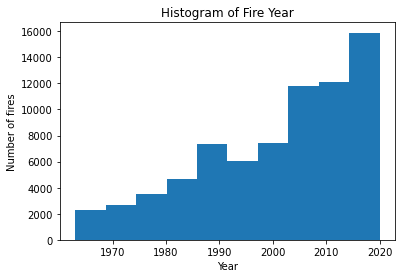

In [8]:
plt.hist(year_extract)
plt.title("Histogram of Fire Year")
plt.ylabel("Number of fires")
plt.xlabel("Year")
plt.show()

In [9]:
from collections import Counter

Counter(year_extract)

Counter({1963: 354,
         1964: 356,
         1965: 317,
         1966: 408,
         1967: 419,
         1968: 413,
         1969: 327,
         1970: 524,
         1971: 374,
         1972: 425,
         1973: 467,
         1974: 552,
         1975: 443,
         1976: 467,
         1977: 468,
         1978: 478,
         1979: 752,
         1980: 894,
         1981: 959,
         1982: 589,
         1983: 774,
         1984: 1021,
         1985: 1336,
         1986: 1188,
         1987: 1563,
         1988: 1485,
         1989: 1250,
         1990: 1018,
         1991: 862,
         1992: 1008,
         1993: 667,
         1994: 1307,
         1995: 858,
         1996: 1381,
         1997: 788,
         1998: 994,
         1999: 1378,
         2000: 1909,
         2001: 1592,
         2002: 1554,
         2003: 1719,
         2004: 1332,
         2005: 1850,
         2006: 2578,
         2007: 2331,
         2008: 2022,
         2009: 1918,
         2010: 1835,
         2011: 215

Based on the graph above, it is evident that the number of fires (as recorded in this dataset) steadily increased over the last 60 years. Specifically, the year 2020 had the most fires (3549). In contrast, the year 1965 had the lowest number of fires (317).

That being said, it is important to note that the the data quality is not consistent over this time range. Data from more recent years is much more accurate due to advances in technology. Thus, the different in the number of fires over the years may not be so severe in actuality.

Now, we look at the other attributes contained in the data.

In [10]:
gj_df_dist['feature'][0]['attributes']

{'OBJECTID': 14299,
 'USGS_Assigned_ID': 14299,
 'Assigned_Fire_Type': 'Wildfire',
 'Fire_Year': 1963,
 'Fire_Polygon_Tier': 1,
 'Fire_Attribute_Tiers': '1 (1), 3 (3)',
 'GIS_Acres': 40992.45827111476,
 'GIS_Hectares': 16589.05930244248,
 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_SubState_MNSRBOPNCA_Wildfires_Historic (1), Comb_SubState_BLM_Idaho_NOC_FPER_Historica_Fire_Polygons (1), Comb_National_BLM_Fire_Perimeters_LADP (1)',
 'Listed_Fire_Types': 'Wildfire (1), Likely Wildfire (3)',
 'Listed_Fire_Names': 'RATTLESNAKE (4)',
 'Listed_Fire_Codes': 'No code provided (4)',
 'Listed_Fire_IDs': '1963-NA-000000 (2)',
 'Listed_Fire_IRWIN_IDs': '',
 'Listed_Fire_Dates': 'Listed Wildfire Discovery Date(s): 1963-08-06 (3) | Listed Wildfire Controlled Date(s): 1963-12-31 (3)',
 'Listed_Fire_Causes': 'Unknown (3)',
 'Listed_Fire_Cause_Class': 'Undetermined (4)',
 'Listed_Rx_Reported_Acres': None,
 'Listed_Map_Digitize_Methods': 'Digitized-Topo (4)',
 'Lis

Upon reviewing the [documentation](https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0%2F63%2F53%2Fd063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true#Entity%20and%20Attribute%20Information) for each of these attributes, *GIS_Acres* is a variable of interest. This variable is defined to be "the GIS calculated acres of the fire polygon calculated by using the Calculate Geometry tool in ArcGIS Pro." Thus, it will give us information regarding the total area of the fire. Once again, I will visualize the distribution of this feature using a histogram.

I decide to transform this variable using natural log, as there is great variation in the size of the data.

In [11]:
acres_extract = []

for i in range(0, len(gj_df_dist)):
    ac = gj_df_dist['feature'][i]['attributes']['GIS_Acres']
    acres_extract.append(ac)

In [12]:
# Log transform data to plot since range is so large
acres_extract = np.array(acres_extract) 
acres_extract_log = np.log(acres_extract)

In [257]:
# Smallest fire
min(acres_extract)

4.697010012483919e-06

In [258]:
# Largest fire
max(acres_extract)

1032651.4212943749

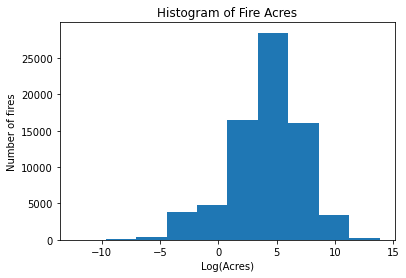

In [15]:
plt.hist(acres_extract_log)
plt.title("Histogram of Fire Acres")
plt.ylabel("Number of fires")
plt.xlabel("Log(Acres)")
plt.show()

Based on the histogram above, the area of the fire (as approximated by *GIS_Acres*) appears to be normally distributed, with a mean around e<sup>5</sup> acres. This is equivalent to approximately 148.41 acres, or about 0.23 square miles.

I am also interested in observing aggregate values for each year. I now calculate the total number of fires for each year, the total acres of land affected by fires for each year, and the total distance of the fires to the city for each year. I will use these aggregate values to calculate averages for each of these measures as well. I will then visualize these values using bar plots.

I also take a look at minimum and maximum values.

In [259]:
# Create dataframe with a column for each variable
year_dist_acres_df = pd.DataFrame(list(zip(year_extract, gj_df_dist['distance'], acres_extract)), columns=['year','distance', 'acres'])

# Show head of dataframe
year_dist_acres_df.head()

,year,distance,acres
0,1963,335.207190,40992.458271
1,1963,307.407123,25757.090203
2,1963,340.695973,45527.210986
3,1963,408.155775,10395.010334
4,1963,350.655777,9983.605738


In [260]:
# Create dataframe and aggregate values
pivot_df = year_dist_acres_df.groupby('year').agg({'distance': ['count', 'sum', 'mean'], 'acres': ['sum', 'mean']})
pivot_df.columns = ['num_fires', 'total_distance', 'avg_distance', 'total_acres', 'avg_acres']
pivot_df = pivot_df.reset_index()

# Show head of dataframe
pivot_df.head()

,year,num_fires,total_distance,avg_distance,total_acres,avg_acres
0,1963,354,216945.788842,612.841211,246695.413455,696.879699
1,1964,356,205524.543055,577.316132,440219.630088,1236.571995
2,1965,317,169980.913529,536.217393,238800.072577,753.312532
3,1966,408,246900.356642,605.147933,696522.359246,1707.162645
4,1967,419,252382.330462,602.344464,476686.936537,1137.677653


In [261]:
# Look at min and max values

# Min total distance
print('min total distance:', min(pivot_df['total_distance']))

# Max total distance
print('max total distance:', max(pivot_df['total_distance']))

# Min total acres
print('min total acres:', min(pivot_df['total_acres']))

# Max total acres
print('max total acres:', max(pivot_df['total_acres']))

min total distance: 169980.9135291853
max total distance: 2414046.8916113144
min total acres: 189029.2575176324
max total acres: 9352218.527754715


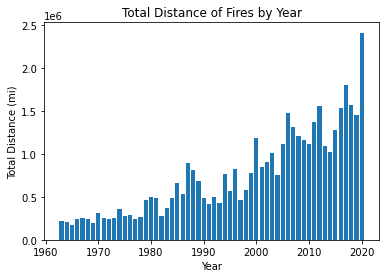

In [262]:
# Plot looking at total distance
plt.bar(pivot_df['year'], pivot_df['total_distance'])
plt.title("Total Distance of Fires by Year")
plt.ylabel("Total Distance (mi)")
plt.xlabel("Year")
plt.show()

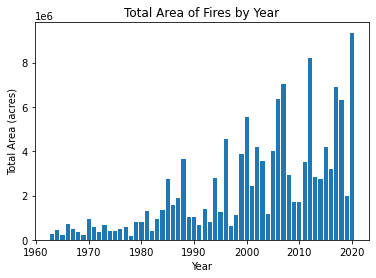

In [263]:
# Plot looking at total area
plt.bar(pivot_df['year'], pivot_df['total_acres'])
plt.title("Total Area of Fires by Year")
plt.ylabel("Total Area (acres)")
plt.xlabel("Year")
plt.show()

As shown above, the total distance from the fires increased over the years, with some periodicity in values over the years. There is a lot of periodicity in the total area of fires by year, but there is a clear upwards trend. This is to be expected, as we observed earlier that the number of fires steadily increased. Now, we will look at the averages for each of these measures to see if the type of fires changed over time. Were the fires that occurred more severe (as measured by the total area covered, and the proximity to the city) on average in later years?

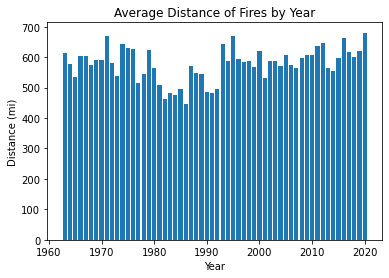

In [264]:
# Plot looking at avg distance
plt.bar(pivot_df['year'], pivot_df['avg_distance'])
plt.title("Average Distance of Fires by Year")
plt.ylabel("Distance (mi)")
plt.xlabel("Year")
plt.show()

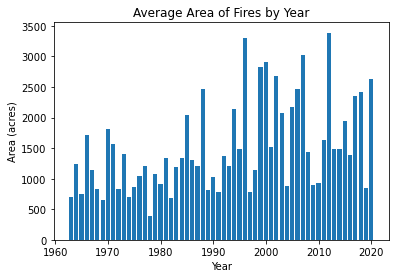

In [265]:
# Plot looking at avg area
plt.bar(pivot_df['year'], pivot_df['avg_acres'])
plt.title("Average Area of Fires by Year")
plt.ylabel("Area (acres)")
plt.xlabel("Year")
plt.show()

Looking at the plots above, there is no clear trend in the average distance of the fires from the city, or the average area of the fires over the years. Thus, I assume that on average, the severity of individual fires did not significantly change year over year.

### Creating an Estimate

I will now define an annual smoke estimate for Longview, based on the distance of each fire from the city, the area covered by each fire, and the number of fires that occurred each year. I will use a weighted average of each of these variables to form my estimate.

In addition, I will structure my estimates so that my values range from 0 to 500. This is because, I will eventually be comparing my smoke estimates to air quality index (AQI) estimates. This index also uses values that primarily range from 0 to 500.

We will first assign each fire a score between 0 and 100, by scaling the distance of the fire. This score will be based on an inverse linear relationship; fires that occurred at a closer distance will receive a higher score (as this is associated with a higher smoke impact), and fires that occurred further away will receive a lower score (as they likely resulted in a lower smoke impact).

We will scale this estimate and consider 3,000 miles to be the greatest possible distance, even though we are only considering fires that occurred within 1,250 miles of Longview. This is because, this [article by NPR](https://www.npr.org/2021/07/21/1018865569/the-western-wildfires-are-affecting-people-3-000-miles-away) describes how smoke from recent fires back in 2021 affected people up to 3,000 miles away.

In [266]:
# Distance score estimate transformation
# Divide distance by 1250 to find percent, then multiply by 100 to scale
# Subtract from 100 as this is an inverse relationship
distance_score = 100 - ((year_dist_acres_df['distance'] / 3000) * 100)

Now, we will similarly assign each fire a score between 0 and 100 based on the area covered by the fire. 

In this case, we will use a linear relationship, as we assume that fires with a greater area will result in a greater smoke impact.

This [article published by USA Today](https://www.usatoday.com/story/news/nation/2023/06/08/largest-us-wildfires-history/70302872007/) outlines the biggest wildfires in the history of the United States. As the 2020 wildfires in California were the largest and covered an estimated 4.4 million acres, we will consider this value to be the greatest area.

In [267]:
# Area score estimate transformation
area_score = ((year_dist_acres_df['acres'])/4400000)*100

We will combine the distance score estimate and area score estimate to assign an overall fire estimate for each fire. We will add these values together to assign a score from 0 to 200 for each fire. We have chosen to weight the distance and area measures equally, as I believe they both contribute equally to smoke impact.

In [268]:
# Combine scores
fire_score = distance_score + area_score

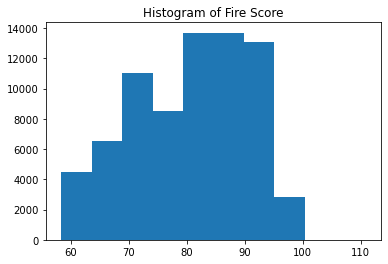

In [269]:
plt.hist(fire_score)
plt.title('Histogram of Fire Score')
plt.show()

As shown above, the overall fire scores range from 0 to 110, and are approximately centered around 85 with a right skew.

Now that we have a score for each fire, we will compute an average fire score for each year. This is calculated by adding all the fire scores for each year, and dividing by the number of fires that occurred in that year.

In [270]:
# Add fire score column to df
year_dist_acres_df['fire_score'] = fire_score

In [376]:
# Calculate mean 'fire score' for each year

average_fire_score_by_year = year_dist_acres_df.groupby('year')['fire_score'].mean()
average_fire_score_by_year = average_fire_score_by_year.reset_index()

# View head of data
average_fire_score_by_year.head()

,year,fire_score
0,1963,79.587798
1,1964,80.784233
2,1965,82.143208
3,1966,79.867201
4,1967,79.947708


Now that we have an average fire score for every year, we will multiply this by a value from 0 to 2.5 based on the number of fires that occurred in that year. This is because, I believe that the number of fires that occurred in the area has a multiplicative impact on annual smoke.

This will adapt our estimator to take the number of fires into account. As our fire score estimates ranged between 0 and 200, our final estimator will range between 0 and 500.

We will calculate our number of fires estimator by scaling the number of fires to a value from 0 to 2.5. According to this [Wikipedia article](https://en.wikipedia.org/wiki/List_of_California_wildfires) regarding the California wildfires (2020) mentioned above, there were 9,639 fires that took place. Thus, we will round and consider 9,650 to be the largest number when scaling.

In [377]:
# Number of fires estimate transformation

num_estimate = ((pivot_df['num_fires'])/3550)*2.5

# Add column to average_fire_score_by_year df
average_fire_score_by_year['num_estimate'] = num_estimate

# Multiply fire_score by num_estimate for final estimator
average_fire_score_by_year['annual_estimate'] = average_fire_score_by_year['fire_score']*average_fire_score_by_year['num_estimate']

# View data
average_fire_score_by_year.head()

,year,fire_score,num_estimate,annual_estimate
0,1963,79.587798,0.249296,19.840902
1,1964,80.784233,0.250704,20.252949
2,1965,82.143208,0.223239,18.337603
3,1966,79.867201,0.287324,22.947759
4,1967,79.947708,0.295070,23.590204


## Data Acquisition: AQI Measures

Now, we want to compare our smoke estimates to Air Quality Index (AQI) measures.  AQI is used to estimate how healthy the air is on a particular day. More information on how the AQI is measured is available at this [link](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf).

We obtain AQI data using the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. Documentation for this API is accessible at this [link](https://aqs.epa.gov/aqsweb/documents/data_api.html).

Code in an example notebook, [US EPA Air Quality System API Example](https://drive.google.com/file/d/1bxl9qrb_52RocKNGfbZ5znHVqFDMkUzf/view?usp=drive_link), provided by Dr. David W McDonald, has been modified and used below. This code has been provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023.

In [79]:
# Code from Dr. McDonald
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests.
#
import requests

We first create constants that we will use later on in our API call.

In [80]:
# Code from Dr. McDonald
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

The code below creates a function, *request_signup*, which facilitates the API sign up request.

In [81]:
# Code from Dr. McDonald
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

I use the function below to specify my email address and request a key. The code should only be run once, and is thus commented out to avoid running again.

In [82]:
# Code from Dr. McDonald
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
#print("Requesting SIGNUP ...")
#response = request_signup("tejalk@uw.edu")
#print(json.dumps(response,indent=4))
#

Upon running the code above, you will receive an email with your API key and a link asking you to confirm your email address. My username and API key are saved in the variables below.

In [83]:
# Save username and api key
USERNAME = "tejalk@uw.edu"
APIKEY = "tealfox37"

I create a function, *request_list_info* to implement a list request. This will allow me to request information regarding lists using the AQI API.

In [86]:
# Code from Dr. McDonald
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

I utilize this function to see the possible parameter classes that I can obtain data for using this API. Based on the options, I find that I am interested in observing the *AQI Pollutants* class. 

In [89]:
# Code from Dr. McDonald
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

As I am interested in information regarding AQI measures, I specify this in a constant below. Then, I view the all the sensors in the *AQI Pollutants* class. The output below shows me sensor numbers as well as a description or name for each sensor.

In [90]:
# Code from Dr. McDonald
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

In [91]:
# Code from Dr. McDonald
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


Thus, I am interested in observing the following attributes: Carbon monoxide, Sulfur dioxide, Nitrogen dioxide (NO2), Ozone, PM10 Total 0-10um STP,  PM2.5 - Local Conditions, and Acceptable PM2.5 AQI & Speciation Mass.

I break the parameters into two lists, one for gaseous pollutants and one for particulate pollutants. This is because, the API only allows for a maximum of 5 sensors per request.

In [92]:
# Code from Dr. McDonald
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

The next step is to create a constants for the coordinates, city, state, county, and FIPS number. The FIPS number is a 5 digit string that specifies the state and county, and has been found using this [link](https://www.census.gov/library/reference/code-lists/ansi.html). Longview, Washington is located in Cowlitz county.

In [93]:
# Create constants
latlon = [46.142614, -122.965558]
city = "Longview"
state = "Washington"
fips = "53015"
county = "Cowlitz"

To find which monitoring stations are near Longview, I will utilize a geographic bounding box. I will use a 100 mile bounding box and observe monitoring stations within 50 miles of Longview. This will allow me to obtain estimates for each of the sensors specified earlier. The function *bounding_latlon* has logic to create a rough estimate for a bounding box around a given place.

In [96]:
# Code from Dr. McDonald

#
#   These are rough estimates for creating bounding boxes based on a city location
#   You can find these rough estimates on the USGS website:
#   https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps
#
LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees

#   The bounding box is scaled in 50 mile increments. That is the bounding box will have sides that
#   are rough multiples of 50 miles, with the center of the box around the indicated place.
#   The scale parameter determines the scale (size) of the bounding box
#

def bounding_latlon(place=None,scale=1.0):
    minlat = latlon[0] - float(scale) * LAT_25MILES
    maxlat = latlon[0] + float(scale) * LAT_25MILES
    minlon = latlon[1] - float(scale) * LON_25MILES
    maxlon = latlon[1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]


The function below, *request_monitors* requests monitoring stations. This allows us to see the monitoring stations and sensors near Longview.

In [126]:
#
#    This implements the monitors request. This requests monitoring stations. This can be done by state, county, or bounding box. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_monitors(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_MONITORS_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

First, we observe the stations for the particulate parameters.

In [131]:
# Code from Dr. McDonald

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES     # particulate request


#   100 mile box - roughly within 50 miles of the location
bbox = bounding_latlon(latlon,scale=2.0)

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]

#
#   we need to change the action for the API from the default to the bounding box - same recent date for now
response = request_monitors(request_template=request_data, begin_date="20210701", end_date="20210731",
                            endpoint_action = API_ACTION_MONITORS_BOX)
#
#
#
if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "state_code": "41",
        "county_code": "009",
        "site_number": "0004",
        "parameter_code": "88502",
        "poc": 3,
        "parameter_name": "Acceptable PM2.5 AQI & Speciation Mass",
        "open_date": "2004-05-01",
        "close_date": null,
        "concurred_exclusions": null,
        "dominant_source": "AREA",
        "measurement_scale": "NEIGHBORHOOD",
        "measurement_scale_def": "500 M TO 4KM",
        "monitoring_objective": "GENERAL/BACKGROUND; REGIONAL TRANSPORT",
        "last_method_code": "771",
        "last_method_description": "Correlated Radiance Research M903 With Heated Inlet - Nephelometry",
        "last_method_begin_date": "2004-05-01",
        "naaqs_primary_monitor": null,
        "qa_primary_monitor": null,
        "monitor_type": "SLAMS",
        "networks": null,
        "monitoring_agency_code": "0821",
        "monitoring_agency": "Oregon Department Of Environmental Quality",
        "si_id": 13100,
        "latitu

From the output above, we can see that these stations give us information on all the following parameters: *PM10 Total 0-10um STP, PM 2.5 - Local Conditions, Acceptable PM2.5 AQI & Speciation Mass*.

Then, we observe the stations for the gaseous parameters.

In [132]:
# Code from Dr. McDonald

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS     # gaseous request


#   100 mile box - roughly within 50 miles of the location
bbox = bounding_latlon(latlon,scale=2.0)

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]

#
#   we need to change the action for the API from the default to the bounding box - same recent date for now
response = request_monitors(request_template=request_data, begin_date="20210701", end_date="20210731",
                            endpoint_action = API_ACTION_MONITORS_BOX)
#
#
#
if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "state_code": "53",
        "county_code": "011",
        "site_number": "0011",
        "parameter_code": "44201",
        "poc": 1,
        "parameter_name": "Ozone",
        "open_date": "1988-05-01",
        "close_date": null,
        "concurred_exclusions": null,
        "dominant_source": null,
        "measurement_scale": "URBAN SCALE",
        "measurement_scale_def": "4 KM TO 50 KM",
        "monitoring_objective": "POPULATION EXPOSURE",
        "last_method_code": "087",
        "last_method_description": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
        "last_method_begin_date": "2008-01-01",
        "naaqs_primary_monitor": "Y",
        "qa_primary_monitor": null,
        "monitor_type": "SLAMS",
        "networks": null,
        "monitoring_agency_code": "1136",
        "monitoring_agency": "Washington State Department Of Ecology",
        "si_id": 16490,
        "latitude": 45.616667,
        "longitude": -122.516667,
        "datum": "WGS84",
        "la

The output above shows us that we can obtain data for the following gaseous parameters: *Carbon monoxide, Sulfur dioxide, Nitrogen dioxide (NO2), Ozone*.

Thus, we are now able to access data for all of the 7 AQI parameters we specified earlier.

Now, we would like to make daily summary requests from each of these stations. As stated earlier, we consider fire season to range between May 1st and October 31st, and will consider the years 1963 - 2023. First, we define a function, *request_daily_summary*.

In [134]:
# Code from Dr. McDonald
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_BOX, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

We will iterate through each of the years to obtain sensor values. We first request data for particulates. 

The idea and technique to convert the API response to a dataframe, particularly the code line `pd.DataFrame(response['Data'])` came from Jenny Wong, another student in the University of Washington Master of Science in Data Science program.

In [156]:
# Code from Dr. McDonald
#    Create a copy of the AQS_REQUEST_TEMPLATE
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES # particulates

#   Now, we need bounding box parameters

#   100 mile box
bbox = bounding_latlon(latlon,scale=2.0)

# the bbox response comes back as a list - [minlat,maxlat,minlon,maxlon]

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]


# Create a loop to iterate through each of the years (1963 - 2023)
# Fire season is considered to be May 1 - October 31

boundbox_particulates_df = pd.DataFrame()

for year in tqdm(range(1963, 2024)): # specifying end date to 2024 gets data until 2023
    response = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031",
                                endpoint_action=API_ACTION_DAILY_SUMMARY_BOX)
    boundbox = pd.DataFrame(response['Data']) # code from Jenny Wong
    boundbox_particulates_df = boundbox_particulates_df.append(boundbox, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [28:38<00:00, 28.17s/it]


We follow the same process for gaseous parameters.

In [166]:
# Code from Dr. McDonald
#    Create a copy of the AQS_REQUEST_TEMPLATE
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS # gaseous

#   Now, we need bounding box parameters

#   100 mile box
bbox = bounding_latlon(latlon,scale=2.0)

# the bbox response comes back as a list - [minlat,maxlat,minlon,maxlon]

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]


# Create a loop to iterate through each of the years (1963 - 2023)
# Fire season is considered to be May 1 - October 31

boundbox_gaseous_df = pd.DataFrame()

for year in tqdm(range(1963, 2024)): # specifying end date to 2024 gets data until 2023
    response = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031",
                                endpoint_action=API_ACTION_DAILY_SUMMARY_BOX)
    boundbox = pd.DataFrame(response['Data']) # code from Jenny Wong
    boundbox_gaseous_df = boundbox_gaseous_df.append(boundbox, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [23:54<00:00, 23.52s/it]


We concatenate both dataframes we have created to form a new dataframe, *boundbox_df*. This dataframe contains daily summary estimates for each of the parameters (including both particulate parameters and gaseous parameters) for the specified time frame.

In [176]:
# Concatenate both dataframes
boundbox_df = pd.concat([boundbox_particulates_df, boundbox_gaseous_df], ignore_index=True,axis=0)

Now, we are interested in finding annual estimates for each parameter. Thus, we create a *year* column for each observation by extracting the year from the field *date_local*. We also only keep the variables were are interested in. We then create a new dataframe, *average_aqi*, in which we store the average estimates for each parameter. Our overall data ranges from 1964 to 2023, however we do not have estimates for each parameter for each of these years.

In [193]:
# Create year column
boundbox_df['year'] = pd.to_datetime(boundbox_df['date_local']).dt.year

# Keep columns of interest (parameter_code, parameter, aqi, year)
boundbox_df = boundbox_df[['parameter_code', 'parameter', 'aqi', 'year']]

In [285]:
# Create new df that averages AQI (groups by parameter and year)
average_aqi = boundbox_df.groupby(['year', 'parameter_code', 'parameter'])['aqi'].mean().reset_index()

In [286]:
# Show head of df
average_aqi.head()

,year,parameter_code,parameter,aqi
0,1964,42401,Sulfur dioxide,NaN
1,1965,42401,Sulfur dioxide,NaN
2,1966,42101,Carbon monoxide,140.631579
3,1966,42401,Sulfur dioxide,31.800000
4,1967,42101,Carbon monoxide,72.918478


We also create a new dataframe, *one_aqi*, where we average all these AQI measures to produce one AQI estimate for each year.

In [287]:
# Average AQI across different parameters
one_aqi = average_aqi.groupby('year')['aqi'].mean().reset_index()

# Show head of df
one_aqi.head()

,year,aqi
0,1964,NaN
1,1965,NaN
2,1966,86.215789
3,1967,53.586957
4,1968,65.636816


## Comparing my Smoke Estimate to AQI Estimates

I will now compare my smoke estimate with AQI estimates for each year. First, I will create one dataframe that contains both sets of values for each year. I create a dataframe called *all_estimates_df*.

In [344]:
# Restructure estimate dataframe
estimate_restructure1 = pd.DataFrame({
    'year': average_fire_score_by_year['year'],  
    'parameter': 'Smoke Estimate',  
    'annual_estimate': average_fire_score_by_year['annual_estimate']
})

# Restructure the aqi dataframe
average_aqi_restructure = average_aqi[['year', 'parameter','aqi']]
average_aqi_restructure.rename(columns={'aqi': 'annual_estimate'}, inplace=True)

# Concatenate both dataframes
all_estimates_df = pd.concat([estimate_restructure1, average_aqi_restructure], ignore_index=True,axis=0)

Then, I plot all measures in a time series plot.

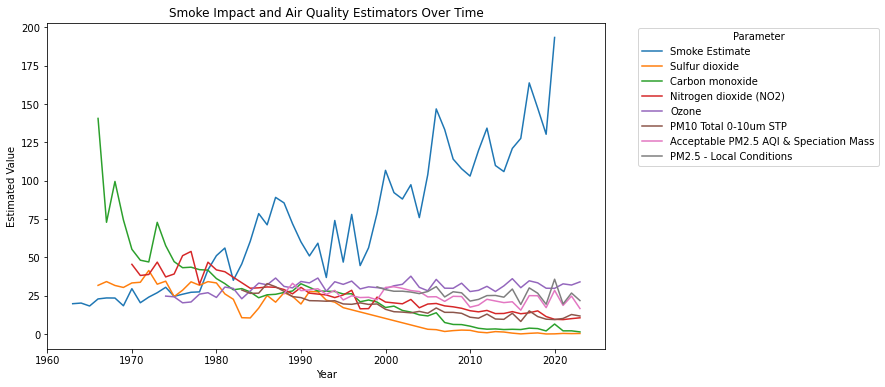

In [346]:
# Plot measures
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_estimates_df, x='year', y='annual_estimate', hue='parameter')
plt.xlabel('Year')
plt.ylabel('Estimated Value')
plt.title('Smoke Impact and Air Quality Estimators Over Time')
plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

I also want to create one measure of AQI, in which all 7 AQI measures are averaged for each year. I create a new dataframe with this measure and my smoke estimates, called *two_estimates_df*. I then create another time series plot in a similar format as above.

In [348]:
# Restructure estimate dataframe
estimate_restructure2 = average_fire_score_by_year[['year','annual_estimate']]
estimate_restructure2['parameter'] = 'Smoke Estimate'

# Restructure one aqi dataframe
one_aqi_restructure = one_aqi.rename(columns={'aqi': 'annual_estimate'})
one_aqi_restructure['parameter'] = 'Average AQI'

# Concatenate both dataframes
two_estimates_df = pd.concat([estimate_restructure2, one_aqi_restructure], ignore_index=True,axis=0)

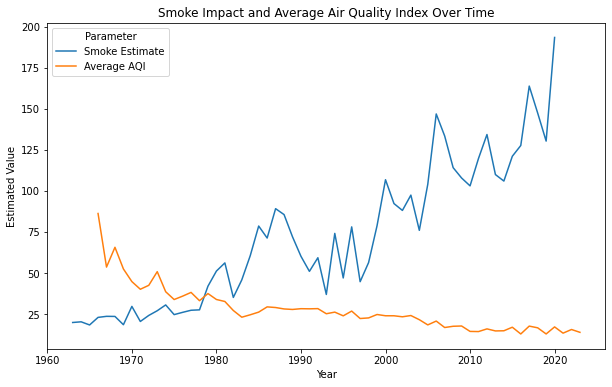

In [595]:
# Plot 2 measures
plt.figure(figsize=(10, 6))
sns.lineplot(data=two_estimates_df, x='year', y='annual_estimate', hue='parameter')
plt.xlabel('Year')
plt.ylabel('Estimated Value')
plt.title('Smoke Impact and Average Air Quality Index Over Time')
plt.legend(title='Parameter')
plt.show()

Upon observing both graphs, it is clear that my smoke impact measure greatly varies from the AQI measures. My smoke estimate steadily increases year over year, whereas the AQI measures appear to be decreasing over time. This is likely because my smoke estimator places a greater weight on the number of fires that occured each year, which was steadily increasing.

In addition, my smoke estimate and AQI measures are not based on the same factors. As mentioned earlier, my smoke estimate is based on the number of fires that occurred each year, the distance of each fire from Longview, and the acres of land the fire burned. On the other hand, AQI measures focus on pollutants such as ozone, particle pollution (particulate matter), carbon monoxide, sulfur dioxide, and nitrogen dioxide. According to the [World Health Organization](https://www.who.int/health-topics/wildfires#tab=tab_1), wildfire smoke is comprised of particulate matter, nitrogen dioxide, ozone, aromatic hydrocarbons, and lead. Our AQI measures do not consider pollutants such as aromatic hydrocarbons and lead.

Although both measures range from 0 to about 500, the categories vary as well. [AQI measures](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) are categorized by the following groups: 0 to 50 is considered *Good*, 51 to 100 is considered *Moderate*, 101 to 150 is considered *Unhealthy for sensitive groups*, 151 to 200 is considered *Unhealthy*, 201 to 300 is considered *Very Unhealthy*, and 301 and higher is considered *Hazardous*. As my smoke measure was linearly scaled from 0 to 500 using measures of the most severe historical fires, I considered values around 500 to be hazardous, rather than starting at 300.

Another factor to consider is the reliability of the earlier AQI and Wildfire data. According to the [Environmental Protection Agency](https://www.epa.gov/outdoor-air-quality-data/why-do-outdoor-air-monitoring-data-summaries-only-go-back-1980-isnt-older), data starting at 1980 should be used to track trends as this marked the start of nationally consistent operational and quality assurance procedures for air quality monitoring. Although data from previous years is available, there is uncertainty in the results. As for the Wildfire data, [NASA](https://earthobservatory.nasa.gov/images/145421/building-a-long-term-record-of-fire) states that satellites began to map fires beginning in the early 1980s. Thus, there is large uncertainty in the data before this time period, as fire-spotting airplanes did not produce as accurate results.

## Creating a Predictive Model

Now, I will create a predictive model based on the fire data and smoke estimate I have created above. In particular, I am interested in predicting yearly smoke estimates for the next 25 years (2024-2049). I will also account for uncertainty in my prediction. 

To build my model, I will be using a univariate time series AutoRegressive Integrated Moving Average (ARIMA) model. More information on ARIMA models can be found [here](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp#:~:text=Autoregressive%20integrated%20moving%20average%20(ARIMA)%20models%20predict%20future%20values%20based,to%20forecast%20future%20security%20prices.). I will use [pmdarima](https://pypi.org/project/pmdarima/), specifically [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) which can be installed using pip.

I have chosen to use an ARIMA model to predict values as I believe this is an appropriate method to work with univariate time series data, since I will be forecasting based solely on my smoke estimate variable. In addition, using my training set of data, I will be able to set values for my moving average and auto regressive terms. This will allow me to assign a more appropriate, higher weight to more recent data. This feature is useful as we know the data quality of more recent data is much higher. 

Code used in this section has been modified from the article [Using Python and Auto ARIMA to Forecast Seasonal Time Series](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c), published on Medium by Jose Marcial Portilla.

In [355]:
# Import packages
from pmdarima.arima import auto_arima

First, we will prepare out data by ensuring that our year column is in a datetime object format and set the index. We will use the *average_fire_score_by_year* dataframe created earlier.

In [391]:
# Convert to datetime
average_fire_score_by_year2 = average_fire_score_by_year.copy(deep=True)

average_fire_score_by_year2['year'] = pd.to_datetime(average_fire_score_by_year2['year'], format='%Y')

# Keep only annual_estimate and year column
average_fire_score_by_year2 = average_fire_score_by_year2[['year','annual_estimate']]

# Set index
average_fire_score_by_year2.set_index('year', inplace=True)

We will plot the data to visualize it.

<AxesSubplot:xlabel='year'>

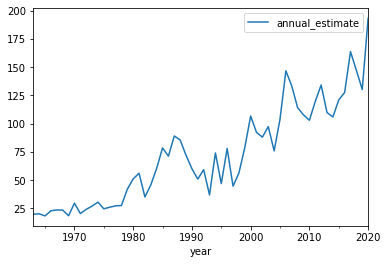

In [398]:
# Plot
average_fire_score_by_year2.plot()

The next step is to split our dataset into a training set and a test set. We will use a 80/20 split, and plot both values. The split point is at 2009.

In [404]:
# Create training and test set
split_point = int(0.8 * len(average_fire_score_by_year2))

train = average_fire_score_by_year2[:split_point]
test = average_fire_score_by_year2[split_point:]

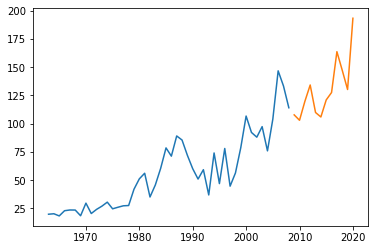

In [405]:
# Visualize data
plt.plot(train)
plt.plot(test)

Now we will use the auto_arima function to find the best fit model using our training data. 

We try p and q values ranging from 1 to 3 to find the most optimal values from the model. The p term indicates the number of auto-regressive terms, which inspects past values. The q term represents the moving average aspect, specifically looking at the number of lagged forecast errors in the prediction. The d term looks at the differencing we will apply to our data. Since our data has a clear upward trend and is not stationary, we will set d=1. We also set m=12 as we observe seasonality in the data above, and set seasonal=True.

The function performs a stepwise search to minimize AIC ([Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)), which can be used to find the best fitting model.

In [433]:
# Code from Jose Marcial Portilla

# We use the auto-arima function to find the best fit model

stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=301.444, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=307.511, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=301.523, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=299.729, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=303.867, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=300.913, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=300.403, Time=0.23 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=303.282, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=301.298, Time=0.34 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total

In [434]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -146.865
Date:                            Wed, 08 Nov 2023   AIC                            299.729
Time:                                    17:03:40   BIC                            304.219
Sample:                                01-01-1963   HQIC                           301.240
                                     - 01-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4243      0.193     -2.199      0.028      -0.802      -0.046
ma.S.L12      -0.7533      0.701     -1.075      0.282      -2.127       0.620
sigma2       330.4910    162.888      2.029      0.042      11.236     649.746
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.93   Prob(JB):                         0.83
Heteroskedasticity (H):               4.03   Skew:                            -0.09
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Thus, the best model is the ARIMA(0,1,1)(0,1,1)[12] model. A model summary is shown above. We will use this model to forecast values on our test set. 

When forecasting values, we will also calculate a 95% confidence interval to create errror bounds and  account for uncertainty.

In [506]:
# Forecast values on test data and create confidence interval
prediction, conf_int = stepwise_model.predict(14,return_conf_int=True,alpha=0.05)

confidence_interval = pd.DataFrame(conf_int)
confidence_interval.columns = ['lower_bound', 'upper_bound']

In [507]:
# Create dataframe for predictions on test data

prediction=pd.DataFrame(stepwise_model.predict(n_periods=14)).reset_index()
prediction['lower_bound'] = confidence_interval['lower_bound']
prediction['upper_bound'] = confidence_interval['upper_bound']
prediction['predicted_estimates'] = prediction[0]
prediction = prediction[['index', 'predicted_estimates', 'lower_bound', 'upper_bound']]
prediction.set_index('index', inplace=True)
prediction

,predicted_estimates,lower_bound,upper_bound
index,,,
2009-01-01,121.350284,84.036202,158.664365
2010-01-01,124.416622,81.360369,167.472875
2011-01-01,137.163226,89.155927,185.170526
2012-01-01,145.394435,92.986770,197.802099
2013-01-01,137.249673,80.783546,193.715800
2014-01-01,133.889938,73.638102,194.141774
2015-01-01,137.793724,73.980371,201.607077
2016-01-01,135.253404,68.067065,202.439744
2017-01-01,138.348586,67.950685,208.746487


We plot our predicted values in green below, and compare this to the test set (in orange). We observe that our predictions are pretty good, as they follow the same general upward trend and similar peaks to our test data. Similarly, our predicted values fall within the 95% confidence interval (indicated by the dotted lines showing the upper and lower bounds).

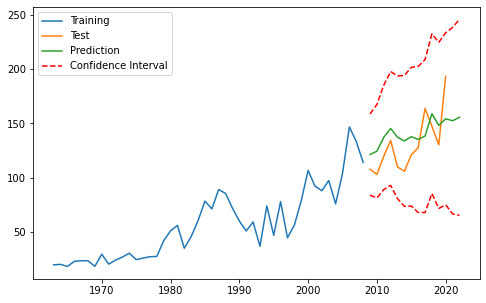

In [518]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction['predicted_estimates'], label='Prediction')
plt.plot(prediction['lower_bound'],color='red', linestyle='--')
plt.plot(prediction['upper_bound'], label='Confidence Interval', color='red', linestyle='--')
plt.plot()
plt.legend()
plt.show()

We now use our ARIMA model (ARIMA(0,1,1)(0,1,1)[12]) to predict values for the next 25 years. Since my fire estimates only go up to 2020 (due to limitations in the original fire data), I will set my forecast periods to 29.

I will use the [SARIMAX package](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html) from statsmodels. First, I create the *model* and save the fitted values in *results*. Next, I forecast for the next 25 years and find the corresponding confidence intervals.

In [555]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore", category=UserWarning)

# Apply ARIMA model to full dataset
model = SARIMAX(average_fire_score_by_year2, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit(disp=False)

warnings.resetwarnings()

In [556]:
# Forecast for 29 periods to get data for up to 2049
forecast_periods = 29
forecast = results.get_forecast(steps=forecast_periods)

# Find estimated values
forecast_mean = forecast.predicted_mean

# Find confidence interval
forecast_confidence_interval = forecast.conf_int()

In [557]:
# Reformat forecast data
smoke_estimate_forecast = pd.DataFrame(forecast_mean)
smoke_estimate_forecast = smoke_estimate_forecast.reset_index()

# Reformat confidence interval data and place in one dataframe
forecast_confidence_interval = forecast_confidence_interval.reset_index()
smoke_estimate_forecast['lower_bound'] = forecast_confidence_interval['lower annual_estimate']
smoke_estimate_forecast['upper_bound'] = forecast_confidence_interval['upper annual_estimate']
smoke_estimate_forecast = smoke_estimate_forecast.rename(columns={'predicted_mean': 'smoke_estimate'})
smoke_estimate_forecast.set_index('index', inplace=True)

# Show final dataframe
smoke_estimate_forecast

,smoke_estimate,lower_bound,upper_bound
index,,,
2021-01-01,165.488533,128.229856,202.747210
2022-01-01,166.266204,124.223087,208.309321
2023-01-01,179.381572,133.181353,225.581791
2024-01-01,187.530747,137.543745,237.517748
2025-01-01,176.916909,123.410472,230.423345
2026-01-01,173.886049,117.077799,230.694299
2027-01-01,179.949028,120.020606,239.877449
2028-01-01,180.458017,117.564025,243.352008
2029-01-01,188.820561,123.094670,254.546451


Thus, the dataframe above shows my smoke estimate forecasted values for the next 25 years, as well as lower and upper bounds (based on a 95% confidence interval) to account for uncertainty in my estimates. I plot the forecasted values below to provide a visual representation.

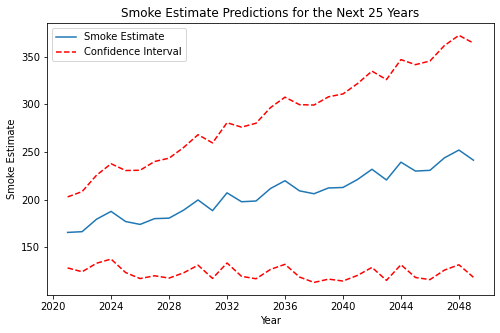

In [585]:
# Plot forecasted values and CI

plt.figure(figsize=(8,5))
plt.plot(smoke_estimate_forecast['smoke_estimate'], label='Smoke Estimate')
plt.plot(smoke_estimate_forecast['lower_bound'],color='red', linestyle='--')
plt.plot(smoke_estimate_forecast['upper_bound'], label='Confidence Interval', color='red', linestyle='--')
plt.plot()
plt.title('Smoke Estimate Predictions for the Next 25 Years')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()

## Visualizations

In this section, I create some plots to visualize different aspects of my analysis. The graphs below visualize data from my analysis range (1963 - 2023).

### Number of Fires by Distance

First, I will produce a histogram to show the number of fires occuring every 50 mile distance from Longview, Washington. The maximum distance in this case will be 1250 miles.

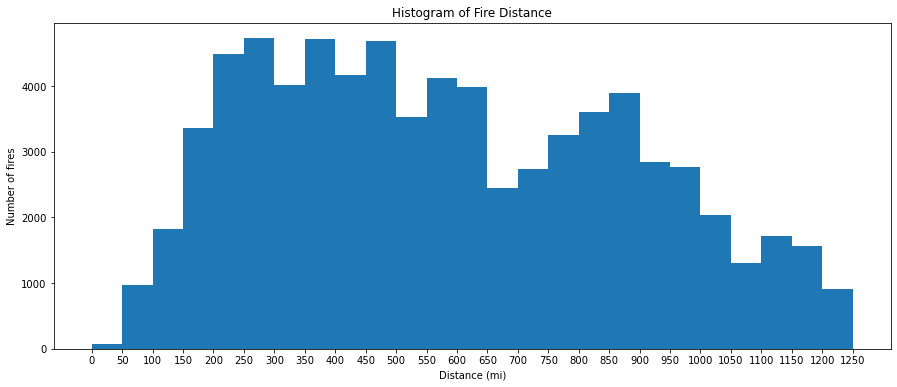

In [571]:
# Plot histogram

# Specify the width of each bin
bin_width = 50

# Calculate the number of bins 
num_bins = int(1250/bin_width)

plt.figure(figsize=(15,6))
plt.hist(gj_df_dist['distance'], bins=num_bins, range=(0, num_bins * bin_width))
plt.title("Histogram of Fire Distance")
plt.ylabel("Number of fires")
plt.xlabel("Distance (mi)")

# Customize the x-axis ticks
plt.xticks(range(0, int(1250) + 1, 50))

plt.show()

### Total Acres Burned per Year

Now, I will observe the total acres burned per year, looking at the fires occurring within 1250 miles of Longview. I will create a time series graph.

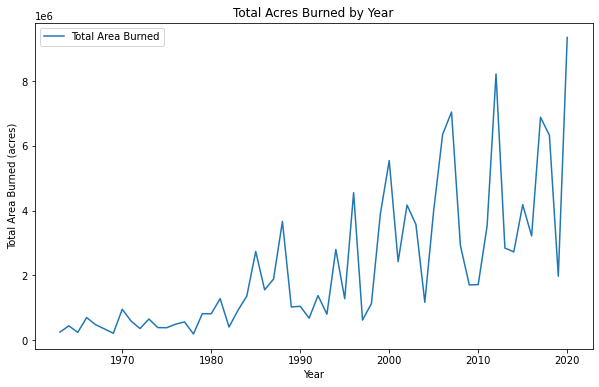

In [586]:
# Time series plot
plt.figure(figsize=(10,6))
plt.plot(pivot_df['year'], pivot_df['total_acres'], linestyle='-', label='Total Area Burned')
plt.title("Total Acres Burned by Year")
plt.ylabel("Total Area Burned (acres)")
plt.xlabel("Year")
plt.legend()
plt.show()

### Fire Smoke Estimate and AQI Estimate

The plots below are time series graphs showing my fire smoke estimate for Longview, as well as the AQI estimates for Longview for each year. The first graph shows my estimate and all 7 AQI measures. The second graph shows my estimate and an average AQI (found by averaging all the 7 AQI measures for each year).

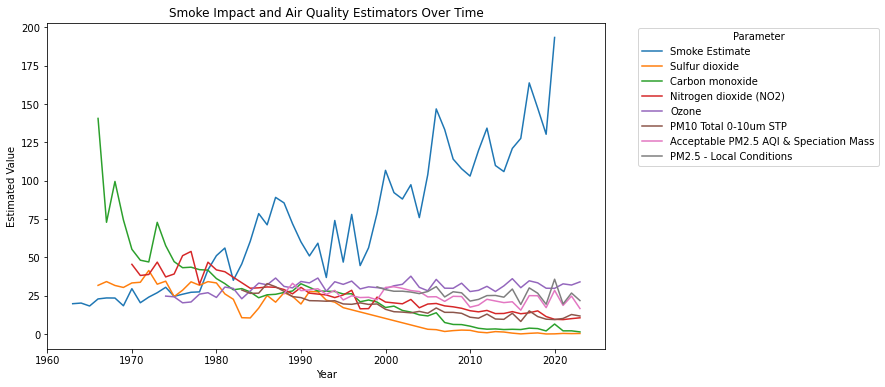

In [582]:
# Plot all measures
plt.figure(figsize=(10, 6))
sns.lineplot(data=all_estimates_df, x='year', y='annual_estimate', hue='parameter')
plt.xlabel('Year')
plt.ylabel('Estimated Value')
plt.title('Smoke Impact and Air Quality Estimators Over Time')
plt.legend(title='Parameter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

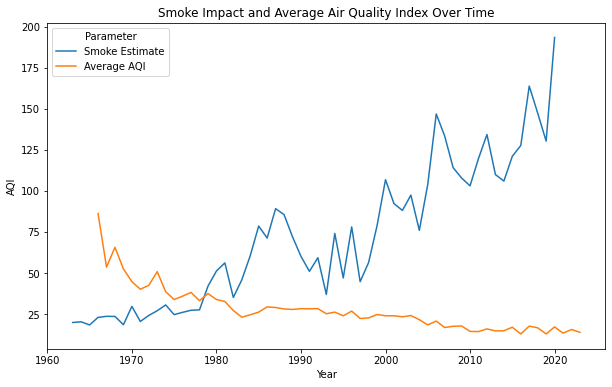

In [583]:
# Plot two measures
plt.figure(figsize=(10, 6))
sns.lineplot(data=two_estimates_df, x='year', y='annual_estimate', hue='parameter')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.title('Smoke Impact and Average Air Quality Index Over Time')
plt.legend(title='Parameter')
plt.show()